## Insurance Cost Prediction

#### Problem Statement
Insurance companies need to accurately predict the cost of health insurance for individuals to set premiums appropriately. However, traditional methods of cost prediction often rely on broad actuarial tables and historical averages, which may not account for the nuanced differences among individuals. By leveraging machine learning techniques, insurers can predict more accurately the insurance costs tailored to individual profiles, leading to more competitive pricing and better risk management.


#### Data description

* 1. **Age:** Numeric, ranging from 18 to 66 years.
* 2. **Diabetes:** Binary (0 or 1), where 1 indicates the presence of diabetes.
* 3. **BloodPressureProblems:** Binary (0 or 1), indicating the presence of blood pressure-related issues.
* 4. **AnyTransplants:** Binary (0 or 1), where 1 indicates the person has had a transplant.
* 5. **AnyChronicDiseases:** Binary (0 or 1), indicating the presence of any chronic diseases.
* 6. **Height:** Numeric, measured in centimeters, ranging from 145 cm to 188 cm.
* 7. **Weight:** Numeric, measured in kilograms, ranging from 51 kg to 132 kg.
* 8. **KnownAllergies:** Binary (0 or 1), where 1 indicates known allergies.
* 9. **HistoryOfCancerInFamily:** Binary (0 or 1), indicating a family history of cancer.
* 10. **NumberOfMajorSurgeries:** Numeric, counting the number of major surgeries, ranging from 0 to 3 surgeries.
* 11. **PremiumPrice:** Numeric, representing the premium price in currency, ranging from 15,000 to 40,000

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr,ttest_ind, mannwhitneyu,kruskal,chi2_contingency, pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from scipy.ndimage import convolve1d
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("insurance.csv")

In [4]:
data.sample(5)

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
506,54,0,0,0,0,184,81,0,0,1,29000
753,30,0,1,0,0,159,87,0,0,1,23000
274,64,1,0,0,0,163,88,0,0,3,28000
670,36,0,0,1,1,166,79,0,0,0,38000
727,45,1,1,0,0,176,58,0,0,0,25000


In [5]:
data.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

In [6]:
data.shape

(986, 11)

In [7]:
data.duplicated().sum()

0

##### Distribution Analysis

In [8]:
data.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000


In [9]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


#### Observations
* Dataset doesn't hold repeated entries and doesn't have null values
* Dataset have all numeric columns--> no need to convert datatypes
* **Height**--> Mean of height is 168, and approximately 68% of the individuals have heights within the 158 - 178 range as std is 10
* **weight** --> mean value and median values are close,  suggesting the central tendency of the data is roughly symmetric. Still, the standard deviation (14) and range(min 51, max 132) highlight possible right-skewness or outliers.
* **age** --> average age is around 42, and std is 13, which indicates how much the ages vary from the mean.
* **PremiumPrice** -> This is our target variable, which shows moderate variation among data values.
* **Binary Features**
  * **Diabetes and BloodPressureProblems** --> Std  0.49 indicates a near-equal distribution of individuals with and without diabetes and blood pressure problems.
  * **AnyTransplants** --> Lower std (0.23) reflects the majority of values are 0, which means most people did not have transplants and indicates an imbalanced dataset. The mean indicates only ~5% of individuals have had transplants, and ~95% have not
  * **AnyChronicDiseases** -->  On average ~18% of individuals have chronic diseases (1), and ~82% do not (0).  Std 0.38 indicates this feature is imbalanced, a majority of values are 0.
  * **KnownAllergies** --> ~21% of individuals have known allergies (1), and ~79% do not (0). Std 0.41, though slightly higher than AnyChronicDiseases, still reflects an imbalance in favor of 0.
  * **HistoryOfCancerInFamily** --> ~12% of individuals have a family history of cancer (1), and ~88% do not (0). Std 0.32 is relatively low, indicating a strong imbalance toward 0.
  * **NumberOfMajorSurgeries** --> The average number of major surgeries is 0.67, suggesting most individuals have undergone less than 1 surgery on average. Std 0.75 shows moderate variability, meaning there’s a wide range in the number of surgeries individuals have had.









#### Actions to take
* Check if features hold outliers. If so, we need to handle outliers.
* Check the nature of the target feature.
* Analyse the distribution of binary features.
* Check colinearity between binary features. 
* Need to perform standardization 
* Handle imbalanced data --> Does Imbalance independent features Directly Impact the Model?  {**If the imbalanced features significantly influence the target variable (e.g., they are strongly correlated or important predictors), the imbalance may need to be addressed.**} 
* Are Binary Features Leading to Model Bias?(*tree based model / linear model*)

#### Univariate Analysis 


Text(0.5, 1.0, 'Age Distribution')

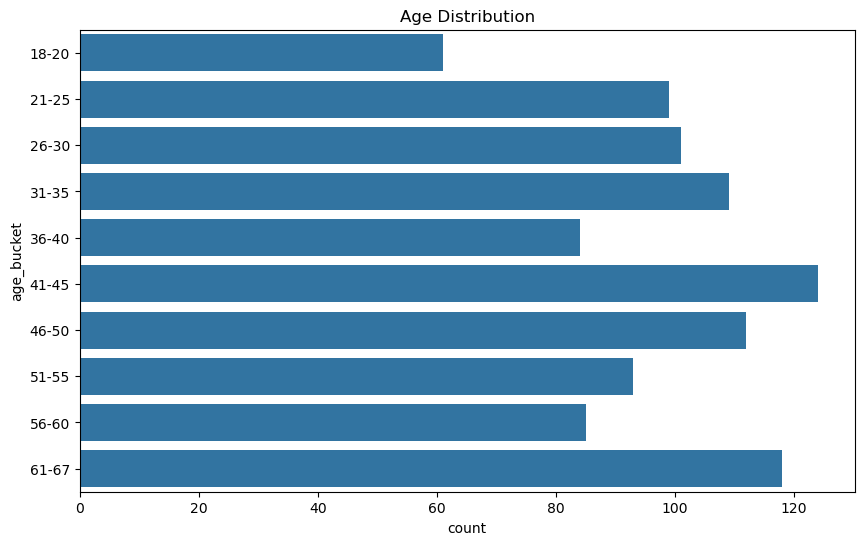

In [10]:
plt.figure(figsize =(10,6))
bins = [18, 21, 26, 31, 36, 41, 46, 51, 56, 61, 67]
labels = ['18-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-67']
data['age_bucket'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
sns.countplot(data['age_bucket'])
plt.title('Age Distribution')

In [11]:
data['age_bucket'].value_counts()

age_bucket
41-45    124
61-67    118
46-50    112
31-35    109
26-30    101
21-25     99
51-55     93
56-60     85
36-40     84
18-20     61
Name: count, dtype: int64

* 18-20, 36-40, and 51-60  age groups are much fewer data points, which may affect analysis or model outcomes if the age-related feature is important.
* Individuals in the 18-20 age category may be students or just starting their careers. As a result, they might not be very interested in purchasing insurance.

Text(0.5, 1.0, 'Weight Distribution')

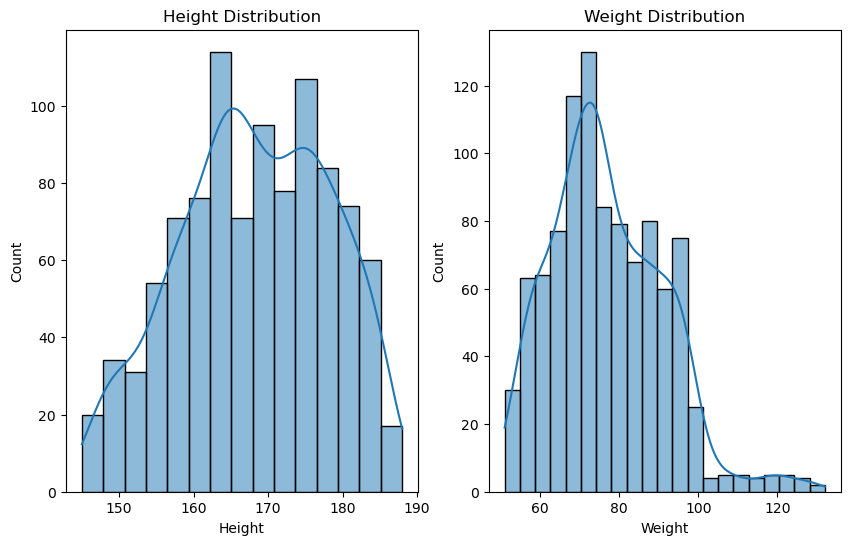

In [12]:
plt.figure(figsize =(10,6))
plt.subplot(1, 2, 1)
sns.histplot(data['Height'], kde = True)
plt.title('Height Distribution')
plt.subplot(1, 2, 2)
sns.histplot(data['Weight'], kde = True)
plt.title('Weight Distribution')

* weight feature is right skewed as few individuals having 100+ weight
* We need to perform more investigation for individuals having 100+ weight as they cannot be considered outliers for data points having 100+.

In [13]:
data['NumberOfMajorSurgeries'].value_counts()

NumberOfMajorSurgeries
0    479
1    372
2    119
3     16
Name: count, dtype: int64

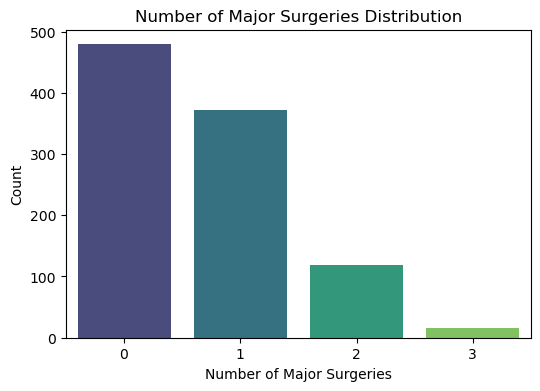

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NumberOfMajorSurgeries', data=data, palette='viridis')
plt.title('Number of Major Surgeries Distribution')
plt.xlabel('Number of Major Surgeries')
plt.ylabel('Count')
plt.show()

* Very few counts have a high number of major surgeries.
* Most of the data points belong to those individuals who haven't done any major surgery or have around one major surgery.

<Figure size 1000x600 with 0 Axes>

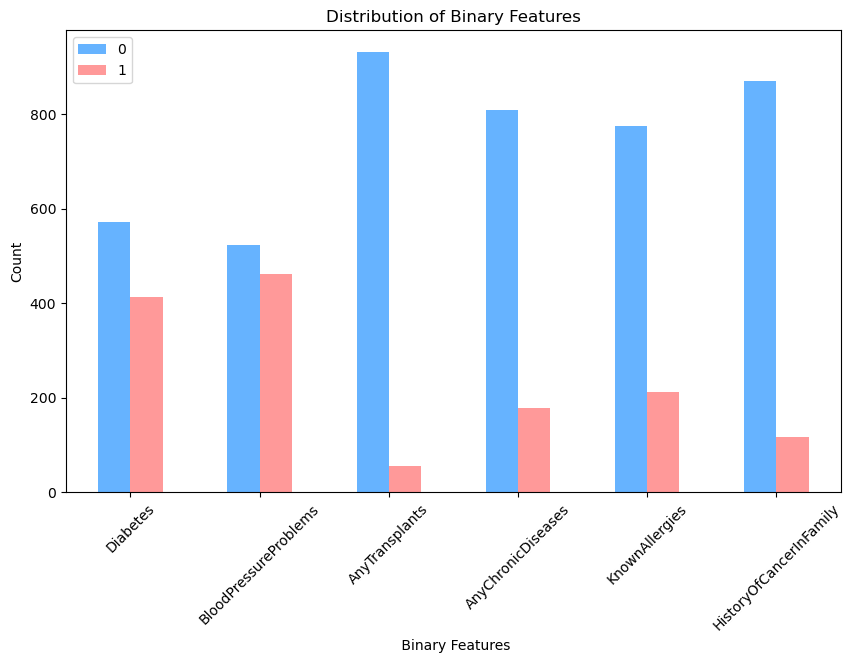

In [15]:
binary_columns = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases',  'KnownAllergies','HistoryOfCancerInFamily',]

# Count 0s and 1s for the each binary columns
counts = data[binary_columns].apply(pd.Series.value_counts).transpose()
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', figsize=(10, 6), color=['#66b3ff', '#ff9999'])
plt.title('Distribution of Binary Features')
plt.xlabel(' Binary Features')
plt.ylabel('Count')
plt.legend(['0', '1'])
plt.xticks(rotation=45)
plt.show()


* Diabetes and BloodPressureProblems features are nearly balanced data. Whereas,  AnyTrasplant, AnyChronicDisease KnownAllergies, and HistoryOfCancerInFamily features are imbalanced.


#### Actions to take

* Need to handle imbalanced binary features as it may impact on model
* To handle imbalanced binary features, we can use **Tree-based models** as these models are less sensitive as models split on feature values. Therefore, they can easily handle binary features regardless of their distribution (whether one value dominates).
* However, the features AnyTrasplant, AnyChronicDisease KnownAllergies, and HistoryOfCancerInFamily are highly imbalanced (e.g., 95% 0 and 5% 1) because this model will prioritize the more frequent value in most splits.
* To handle this we can use **regularization techniques, Re-sampling** (only on training data) and **Feature Engineering** to create composite features.

<Axes: xlabel='PremiumPrice', ylabel='Count'>

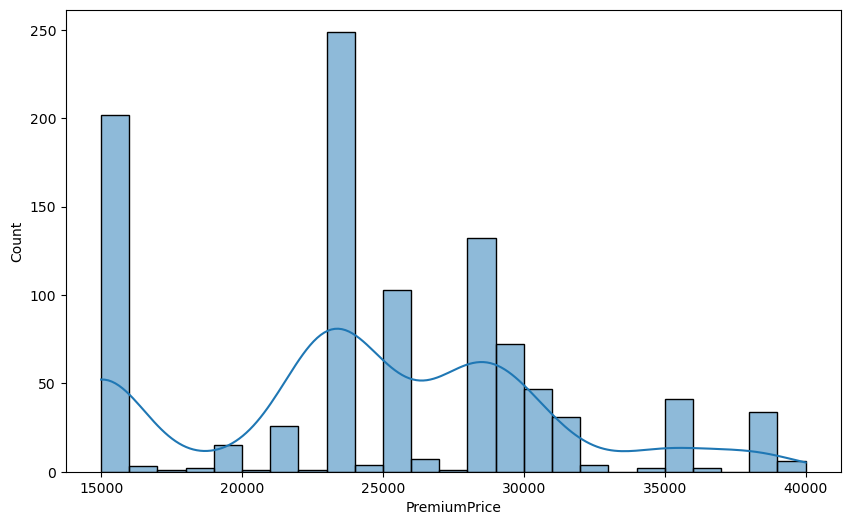

In [16]:
plt.figure(figsize =(10,6))
sns.histplot(data['PremiumPrice'], kde= True, bins = 25)

In [17]:
sorted(data['PremiumPrice'].unique())

[15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 34000,
 35000,
 36000,
 38000,
 39000,
 40000]

 * premium range is from 15000- 40000 and data is missing for 37000 this price premium 
 *  The most frequent premium prices are 23,000 and 15,000, indicating that these are a popular choice amongst individuals.
 * The target feature have unique values in discrete nature, for prediction we can use linear regression.
 * These values, while discrete, are not in a perfectly smooth range. They represent distinct clusters or ranges of premiums, which suggests that this problem could potentially be treated as a classification problem.

##### Actions to take 
* Need handle imbalanced for target featurein data preprocessing phase.
* We can use **Label Distribution Smoothing (LDS)** technique this will help to smoothing to the target values (labels) by considering the similarity between nearby target values.
*  In LDS we can use **Gaussian smoothing** or **kernel density estimation** if needed.
*  https://chatgpt.com/c/678e73c9-f4cc-8001-8223-5cb1ec74e5f2 --> multiclass vs multilevel

In [18]:
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,age_bucket
0,45,0,0,0,0,155,57,0,0,0,25000,41-45
1,60,1,0,0,0,180,73,0,0,0,29000,56-60
2,36,1,1,0,0,158,59,0,0,1,23000,36-40
3,52,1,1,0,1,183,93,0,0,2,28000,51-55
4,38,0,0,0,1,166,88,0,0,1,23000,36-40


In [19]:
age_grouped = (
    data.groupby(by="age_bucket")["Diabetes"]
    .apply(lambda x: (x == 1).sum()) 
    .reset_index(name="Diabetes_Count") 
)

In [20]:
age_grouped

,age_bucket,Diabetes_Count
0,18-20,16
1,21-25,33
2,26-30,36
3,31-35,30
4,36-40,29
5,41-45,51
6,46-50,56
7,51-55,44
8,56-60,47
9,61-67,72


In [21]:
data['Diabetes'].value_counts()

Diabetes
0    572
1    414
Name: count, dtype: int64

In [22]:
age_grouped = (
    data.groupby(by="age_bucket")
    .agg(
        Diabetes_Count=("Diabetes", lambda x: (x == 1).sum() if len(x) > 0 else 0),
        BloodPressureProblems_Count=("BloodPressureProblems",lambda x: (x == 1).sum() if len(x) > 0 else 0), 
        AnyTransplants_Count=("AnyTransplants", lambda x: (x == 1).sum() if len(x) > 0 else 0),
        AnyChronicDiseases_Count=("AnyChronicDiseases", lambda x: (x == 1).sum() if len(x) > 0 else 0),
        KnownAllergies_Count=("KnownAllergies", lambda x: (x == 1).sum() if len(x) > 0 else 0),
        HistoryOfCancerInFamily_Count=("HistoryOfCancerInFamily", lambda x: (x == 1).sum() if len(x) > 0 else 0)
    )
    .reset_index()
)

In [23]:
age_grouped

,age_bucket,Diabetes_Count,BloodPressureProblems_Count,AnyTransplants_Count,AnyChronicDiseases_Count,KnownAllergies_Count,HistoryOfCancerInFamily_Count
0,18-20,16,13,1,0,16,9
1,21-25,33,42,10,5,23,12
2,26-30,36,33,4,24,19,13
3,31-35,30,47,8,24,19,12
4,36-40,29,34,5,21,24,10
5,41-45,51,47,6,30,23,14
6,46-50,56,55,4,24,33,16
7,51-55,44,52,5,20,14,11
8,56-60,47,55,7,14,20,7
9,61-67,72,84,5,16,21,12


In [24]:
age_surgery = data.groupby(by="age_bucket")["NumberOfMajorSurgeries"].max().reset_index(name="noOfMajorSurgeries")


In [25]:
age_surgery

,age_bucket,noOfMajorSurgeries
0,18-20,1
1,21-25,1
2,26-30,1
3,31-35,1
4,36-40,1
5,41-45,1
6,46-50,2
7,51-55,2
8,56-60,2
9,61-67,3


##### Find correlation between Age, Diabetes and Blood pressure

In [26]:
diabetes_corr, diabetes_p_value = pointbiserialr(data['Age'], data['Diabetes'])
blood_pressure_corr, blood_pressure_p_value = pointbiserialr(data['Age'], data['BloodPressureProblems'])

print(f"Correlation between Age and Diabetes: {diabetes_corr:.4f}, p-value: {diabetes_p_value:.4f}")
print(f"Correlation between Age and BloodPressureProblems: {blood_pressure_corr:.4f}, p-value: {blood_pressure_p_value:.4f}")

Correlation between Age and Diabetes: 0.2109, p-value: 0.0000
Correlation between Age and BloodPressureProblems: 0.2449, p-value: 0.0000


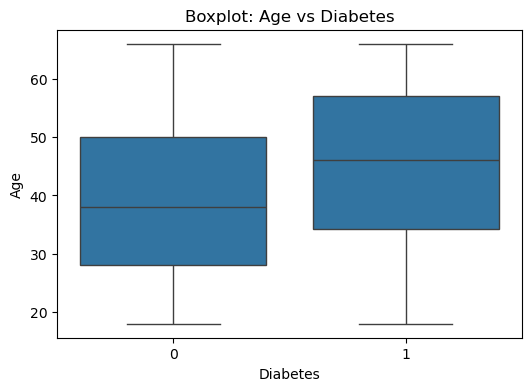

In [27]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Diabetes', y='Age', data=data)
plt.title("Boxplot: Age vs Diabetes")
plt.show()

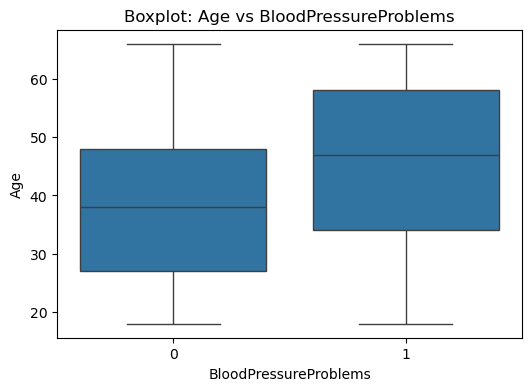

In [28]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='BloodPressureProblems', y='Age', data=data)
plt.title("Boxplot: Age vs BloodPressureProblems")
plt.show()

* Every age group has diabetes and blood pressure issues. As age increases, cases of diabetes and blood pressure also increasing
* Whether the person has had a transplant or not does not depend on the age of the person
* Below age 21, doesn't have chronic diseases. Age doesn't influence chronic diseases
* Counting the number of major surgeries and family history of cancer does not depend on age
  

##### Actions to take 


* Find colinearity between age, diabetes, and blood pressure. If these features have any relation, we can create new features to reduce colinearity
* Find if there is any relation between any chronic disease and a history of cancer.

In [29]:
age_price_mode = (
    data.groupby(by='age_bucket')['PremiumPrice']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)  # Get the first mode
    .reset_index(name='Mode_PremiumPrice')
)

In [30]:
age_price_mode

,age_bucket,Mode_PremiumPrice
0,18-20,15000
1,21-25,15000
2,26-30,15000
3,31-35,23000
4,36-40,23000
5,41-45,23000
6,46-50,25000
7,51-55,28000
8,56-60,28000
9,61-67,28000


* As age increases, premium prices also increase
* But the most frequent premium prices are 23,000 and 15,000.

##### Action to take
**make a group of premium prices like, below 20000, then between 21000 and 30000, and above 30000. Then, check the behavior of each age group in this range**

In [31]:
data['PremiumPrice'].min()

15000

In [32]:
data['PremiumPrice'].max()

40000

In [33]:
bins = [0, 20000, 30000, 41000] 
labels = ['Below 20000', '21000-30000', 'Above 30000']
data['price_range'] = pd.cut(data['PremiumPrice'], bins=bins, labels=labels, right=False)

In [34]:
age_price_grouped = (
    data.groupby(['age_bucket', 'price_range']).size().reset_index(name='Count')
)

In [35]:
age_price_grouped 

,age_bucket,price_range,Count
0,18-20,Below 20000,58
1,18-20,21000-30000,2
2,18-20,Above 30000,1
3,21-25,Below 20000,91
4,21-25,21000-30000,3
5,21-25,Above 30000,5
6,26-30,Below 20000,71
7,26-30,21000-30000,26
8,26-30,Above 30000,4
9,31-35,Below 20000,0


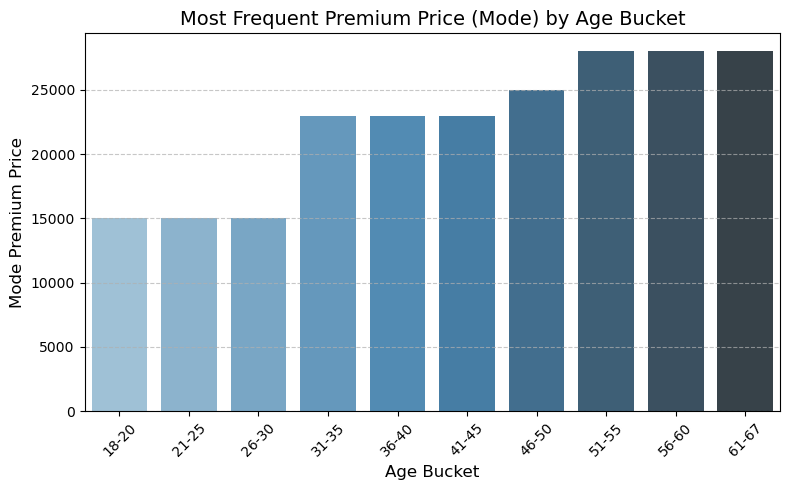

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(x='age_bucket', y='Mode_PremiumPrice', data=age_price_mode, palette='Blues_d')
plt.title('Most Frequent Premium Price (Mode) by Age Bucket', fontsize=14)
plt.xlabel('Age Bucket', fontsize=12)
plt.ylabel('Mode Premium Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
data.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice',
       'age_bucket', 'price_range'],
      dtype='object')

* Age between 18 and 30 prefer a premium of rupees 15000. After that, as age increases, the premium price increases.

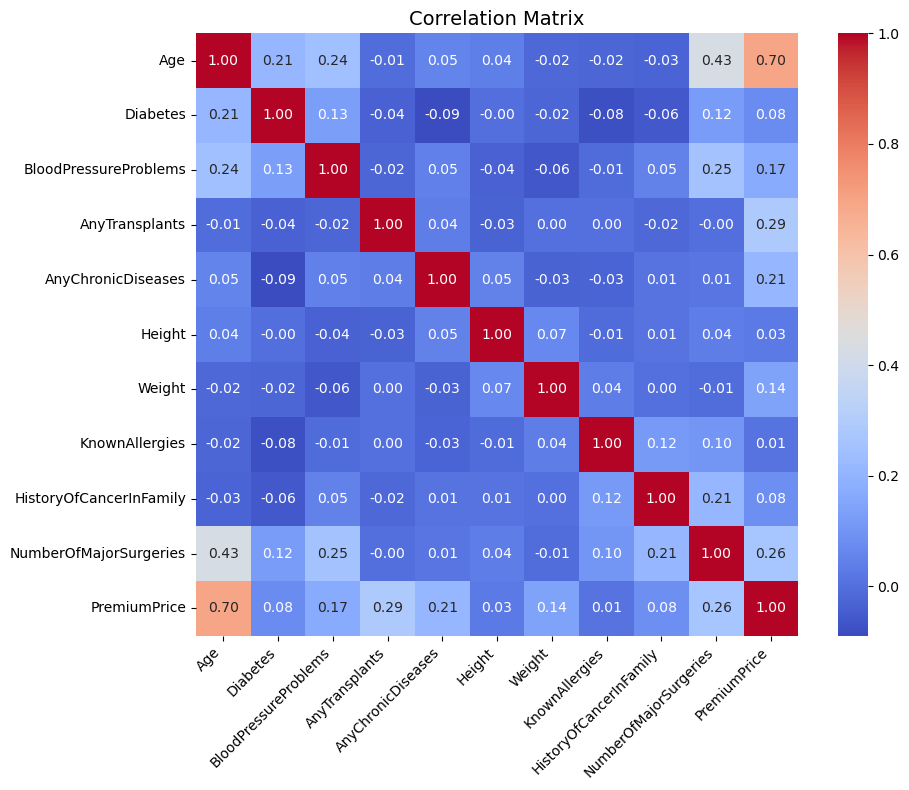

In [38]:
filtered_data = data.drop(columns = ['age_bucket', 'price_range'])
correlation_matrix = filtered_data.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Outlier Detection

* **Binary Features** - ['Diabetes', 'BloodPressureProblems', 'AnyTransplants','AnyChronicDiseases',  'KnownAllergies','HistoryOfCancerInFamily'] : These have only two values (e.g., 0 and 1), so outlier detection isn't applicable.
* **Ordinal Features** - 'NumberOfMajorSurgeries' -->outlier detection isn't applicable.
* **Discrete and Continuous Features** - ['Age','Height', 'Weight','PremiumPrice'] -> Use traditional outlier detection methods like the IQR method or Z-scores

In [39]:
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

In [40]:
def detect_outliers_zscore(column, threshold=3):
    mean = column.mean()
    std = column.std()
    z_scores = (column - mean) / std
    outliers = column[np.abs(z_scores) > threshold]
    return outliers

In [41]:
outliers_summary = {}
for col in ['Age','PremiumPrice']:
    outliers_iqr = detect_outliers_iqr(data[col])
    outliers_summary[col] = {
        'IQR Outlier Count': len(outliers_iqr),
        'IQR Outliers': outliers_iqr.tolist()
    }

In [42]:
outliers_summary

{'Age': {'IQR Outlier Count': 0, 'IQR Outliers': []},
 'PremiumPrice': {'IQR Outlier Count': 6,
  'IQR Outliers': [39000, 40000, 39000, 39000, 39000, 39000]}}

In [43]:
filtered_data = data[data['PremiumPrice'].apply(lambda x: x == 39000 or x == 40000)]



In [44]:
filtered_data

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,age_bucket,price_range
204,27,0,1,0,0,159,120,1,1,1,39000,26-30,Above 30000
295,64,1,1,0,1,163,91,0,0,2,40000,61-67,Above 30000
926,24,0,1,0,0,159,67,0,0,0,39000,21-25,Above 30000
928,19,0,0,0,0,171,67,0,0,1,39000,18-20,Above 30000
976,21,0,1,0,0,155,74,0,0,0,39000,21-25,Above 30000
984,47,1,1,0,0,158,73,1,0,1,39000,46-50,Above 30000


In [45]:
iqr_zscore_outlier = {}
for col in ['Height', 'Weight']:
    outliers_iqr = detect_outliers_iqr(data[col])
    outliers_zscore = detect_outliers_zscore(data[col])
    
    iqr_zscore_outlier[col] = {
        'IQR Outlier Count': len(outliers_iqr), 
        'IQR Outliers': outliers_iqr.tolist(), 
        'Z-score Outlier Count': len(outliers_zscore),
        'Z-score Outliers': outliers_zscore.tolist() 
       
        
    }


In [46]:
iqr_zscore_outlier

{'Height': {'IQR Outlier Count': 0,
  'IQR Outliers': [],
  'Z-score Outlier Count': 0,
  'Z-score Outliers': []},
 'Weight': {'IQR Outlier Count': 16,
  'IQR Outliers': [118,
   121,
   119,
   129,
   127,
   132,
   120,
   128,
   120,
   123,
   126,
   121,
   118,
   128,
   124,
   122],
  'Z-score Outlier Count': 13,
  'Z-score Outliers': [121,
   129,
   127,
   132,
   120,
   128,
   120,
   123,
   126,
   121,
   128,
   124,
   122]}}

In [47]:
find_outlier = data[data['Weight'].apply(lambda x : x in [118,121,119,129,127,132,120,128,120,123,126,121,118,128,124,122] )]

In [48]:
find_outlier

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,age_bucket,price_range
154,21,0,0,0,0,157,118,1,0,1,15000,21-25,Below 20000
158,43,0,0,0,0,158,121,0,0,0,23000,41-45,21000-30000
183,36,0,0,0,0,156,119,0,0,0,23000,36-40,21000-30000
186,19,0,0,0,0,173,129,1,0,0,15000,18-20,Below 20000
192,50,1,0,0,0,163,127,0,0,2,28000,46-50,21000-30000
195,19,0,0,0,0,164,132,0,0,0,15000,18-20,Below 20000
196,39,0,1,0,0,174,120,0,0,0,23000,36-40,21000-30000
203,24,0,1,0,0,173,128,0,0,1,26000,21-25,21000-30000
204,27,0,1,0,0,159,120,1,1,1,39000,26-30,Above 30000
207,18,0,0,0,0,172,123,0,1,1,15000,18-20,Below 20000


* The **Age** and **Height** features do not contain any outliers.
* For the **PremiumPrice** feature, while it initially appears to have outliers, further investigation reveals the following:
    * Individuals over 60 years old who have undergone 2 major surgeries and are dealing with diabetes, blood pressure issues, and chronic diseases often choose a premium insurance plan priced at 40,000.
    * Individuals with 1 major surgery, weight issues, blood pressure problems, and some known allergies tend to opt for a premium insurance plan priced at 39,000.
    * Similarly, individuals without any major surgeries but with blood pressure issues also prefer the 39,000 premium insurance plan.
In all these scenarios, the purchase of higher premium insurance plans is justified, meaning these are not outliers that should be removed from the dataset.
* The **weight** feature has outliers, but it also shows information about the number of surgeries individuals have done. Therefore, we should not remove these data points. 

#### Actions to take

* **Handle outliers**
  * **Capping**: We can use the capping method to replace the extreme values with the nearest non-outlier value within a specific range.
  * We can apply **Log transformation**
  * we can create a new column to **segment customers** based on the observed health profiles 

In [49]:
# def segment_customers(row):
#     if row['Age'] > 60 and row['Surgeries'] >= 2 and row['ChronicIllness'] == 1:
#         return 'high_risk'
#     elif row['Surgeries'] == 1 and row['WeightIssues'] == 1 and row['BloodPressure'] == 1:
#         return 'medium_risk'
#     elif row['Surgeries'] == 0 and row['BloodPressure'] == 1:
#         return 'medium_risk'
#     else:
#         return 'low_risk'

# # Apply segmentation
# data['RiskSegment'] = data.apply(segment_customers, axis=1)
# print(data['RiskSegment'].value_counts())

##### Compute correlation between binary features

In [50]:

binary_features = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants',
                   'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']
correlation_matrix = data[binary_features].corr(method='pearson')
correlation_matrix


,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily
Diabetes,1.000000,0.127727,-0.036652,-0.089428,-0.080102,-0.055527
BloodPressureProblems,0.127727,1.000000,-0.024538,0.045424,-0.011550,0.048239
AnyTransplants,-0.036652,-0.024538,1.000000,0.035285,0.001876,-0.020171
AnyChronicDiseases,-0.089428,0.045424,0.035285,1.000000,-0.027418,0.008666
KnownAllergies,-0.080102,-0.011550,0.001876,-0.027418,1.000000,0.115383
HistoryOfCancerInFamily,-0.055527,0.048239,-0.020171,0.008666,0.115383,1.000000


* Almost all pairwise correlations are very close to 0, meaning that the binary features are mainly independent of each other and don't have a strong relation
* The correlation between **Diabetes** and **BloodPressureProblems** is 0.127, showing a **weak positive correlation**.
* The correlation between **AnyChronicDiseases** and **KnownAllergies** is -0.027, indicating a **weak negative correlation** between these two features.
* The interesting pairs **KnownAllergies** and **HistoryOfCancerInFamily** have the highest correlation, 0.115, which is still weak but worth noting.

#### Actions to take
*  There is no need to drop or combine these features, as they are not strongly correlated.
*  Each binary feature can provide unique information to the model without redundancy.
*  We can check multicollinearity between these features.

In [51]:
binary_features = data[['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily','NumberOfMajorSurgeries']]
vif = pd.DataFrame()
vif["binary"] = binary_features.columns
vif["VIF"] = [variance_inflation_factor(binary_features.values, i) for i in range(binary_features.shape[1])]
vif

,binary,VIF
0,Diabetes,1.485400
1,BloodPressureProblems,1.780855
2,AnyTransplants,1.039127
3,AnyChronicDiseases,1.146890
4,KnownAllergies,1.208010
5,HistoryOfCancerInFamily,1.191486
6,NumberOfMajorSurgeries,1.909215


* All the features have VIF values close to 1, which indicates no significant correlation with other features in the dataset.
* This confirms that none of the binary features are strongly dependent on a combination of others.
  

##### Compute relationship of binary features with target feature

In [52]:
binary_features = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants',
                   'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily','NumberOfMajorSurgeries']
for feature in binary_features:
    correlation, p_value = pointbiserialr(data[feature], data['PremiumPrice'])
    print(f"{feature}: correlation = {correlation:.3f}, p = {p_value:.3f}")


Diabetes: correlation = 0.076, p = 0.017
BloodPressureProblems: correlation = 0.167, p = 0.000
AnyTransplants: correlation = 0.289, p = 0.000
AnyChronicDiseases: correlation = 0.209, p = 0.000
KnownAllergies: correlation = 0.012, p = 0.704
HistoryOfCancerInFamily: correlation = 0.083, p = 0.009
NumberOfMajorSurgeries: correlation = 0.264, p = 0.000


* Having diabetes is weakly associated with a higher premium price, but the relationship is significant.
* Blood pressure problems are moderately associated with higher premium prices.
* A history of transplants shows a strong and significant association with higher premium prices.
* Chronic diseases are moderately and significantly associated with higher premium prices.
* Known allergies do not show any meaningful association with premium prices.
* A family history of cancer has a weak but significant association with higher premium prices.


#### Hypothesis testing

##### correlation between continuous feature and premium price
* **Pearson correlation** : If data is normally distibuted. (Age, Height)
* **Spearman correlation** : If data is not normally dustibuted (Weight)

#### Find out corelation between age and premium price

In [53]:
h0 = "There is no significant correlation between age and the premium price."
ha = "There is a significant correlation between age and the premium price."
alpha = 0.05
pearson_corr, p_value = pearsonr(data['Age'], data['PremiumPrice'])

if p_value < 0.05:
    print("reject the null hypothesis. Conclude that there is a significant difference in premium prices and age")
else:
    print(" fail to reject the null hypothesis. Conclude that there is no significant difference in premium prices and given age")



reject the null hypothesis. Conclude that there is a significant difference in premium prices and age


#### Find out correlation between height and premium price

In [54]:
h0 = "There is no significant correlation between height and the premium price."
ha = "There is a significant correlation between height and the premium price."
alpha = 0.05
pearson_corr, p_value = pearsonr(data['Height'], data['PremiumPrice'])

if p_value < 0.05:
    print("reject the null hypothesis. Conclude that there is a significant difference in premium prices and height")
else:
    print(" fail to reject the null hypothesis. Conclude that there is no significant difference in premium prices and given height")


 fail to reject the null hypothesis. Conclude that there is no significant difference in premium prices and given height


#### Find out correlation between weight and premium price

In [55]:
h0 = "There is no significant correlation between weight and the premium price."
ha = "There is a significant correlation between weight and the premium price."
alpha = 0.05
spearman_corr, p_value = spearmanr(data['Weight'], data['PremiumPrice'])
if p_value < 0.05:
    print("reject the null hypothesis. Conclude that there is a significant difference in premium prices and weight")
else:
    print(" fail to reject the null hypothesis. Conclude that there is no significant difference in premium prices and given weight")


reject the null hypothesis. Conclude that there is a significant difference in premium prices and weight


#### Compare the means of premium prices across different groups defined by categorical variables

* **Binary Features** - ['Diabetes', 'BloodPressureProblems', 'AnyTransplants','AnyChronicDiseases', 'KnownAllergies','HistoryOfCancerInFamily']
* Use **Mann-Whitney** U Test (if outliers are present)or **independent** t-test.

##### Premium price and diabetes

In [56]:
diabetes_0 = data[data['Diabetes'] == 0]['PremiumPrice']
diabetes_1 = data[data['Diabetes'] == 1]['PremiumPrice']

H0 = "There is no significant difference in premium prices between individuals with and without diabetes."
Ha = "There is a significant difference in premium prices between individuals with and without diabetes."
alpha = 0.05 
# Independent t-test
t_stat, p_value = ttest_ind(diabetes_0, diabetes_1, equal_var=True)
if p_value < 0.05:
    print("reject the null hypothesis. Conclude that there is a significant difference in premium prices between individuals with and without diabetes.")
else:
    print(" fail to reject the null hypothesis. Conclude that there is no significant difference in premium price between individuals with and without diabetes.")
    


reject the null hypothesis. Conclude that there is a significant difference in premium prices between individuals with and without diabetes.


##### blood pressure problem and premium price

In [57]:
bp_0 = data[data['BloodPressureProblems'] == 0]['PremiumPrice']
bp_1 = data[data['BloodPressureProblems'] == 1]['PremiumPrice']

H0 = "There is no significant difference in premium prices between individuals with and without BloodPressureProblems"
Ha = "There is a significant difference in premium prices between individuals with and without BloodPressureProblems"
alpha = 0.05 
# Independent t-test
t_stat, p_value = ttest_ind(bp_0, bp_1, equal_var=True)
if p_value < 0.05:
    print("reject the null hypothesis. Conclude that there is a significant difference in premium prices between individuals with and without diabetes.")
else:
    print(" fail to reject the null hypothesis. Conclude that there is no significant difference in premium price between individuals with and without diabetes.")
    


reject the null hypothesis. Conclude that there is a significant difference in premium prices between individuals with and without diabetes.


##### chronic diseases and premium price

In [58]:
chronic_0 = data[data['AnyChronicDiseases'] == 0]['PremiumPrice']
chronic_1 = data[data['AnyChronicDiseases'] == 1]['PremiumPrice']
H0= "There is no significant difference in premium prices between individuals with and without a any chronic diseases."
Ha= "There is a significant difference in premium prices between individuals with and without a any chronic diseases."
alpha = 0.05
u_stat, p_value = mannwhitneyu(chronic_0, chronic_1, alternative='two-sided')
if p_value < 0.05:
    print("reject the null hypothesis. There is a significant difference in premium prices between individuals with and without a any chronic diseases")
else:
    print(" fail to reject the null hypothesis. There is no significant difference in premium prices between individuals with and without a any chronic diseases.")
    


reject the null hypothesis. There is a significant difference in premium prices between individuals with and without a any chronic diseases


##### Any transplant and premium price 

In [59]:
trans_0 = data[data['AnyTransplants'] == 0]['PremiumPrice']
trans_1 = data[data['AnyTransplants'] == 1]['PremiumPrice']
H0= "There is no significant difference in premium prices between individuals with and without a history of transplants."
Ha= "There is a significant difference in premium prices between individuals with and without a history of transplants."
alpha = 0.05
u_stat, p_value = mannwhitneyu(trans_0, trans_1, alternative='two-sided')
if p_value < 0.05:
    print("reject the null hypothesis. There is a significant difference in premium prices between individuals with and without a history of transplants.")
else:
    print(" fail to reject the null hypothesis. There is no significant difference in premium prices between individuals with and without a history of transplants.")
    

reject the null hypothesis. There is a significant difference in premium prices between individuals with and without a history of transplants.


##### Number of major surgeries and Premium price

In [60]:
H0 = "The number of major surgeries does not significantly affect the premium price."

Ha="The number of major surgeries significantly affects the premium price."
alpha = 0.05
surgery_groups = [group['PremiumPrice'] for _, group in data.groupby('NumberOfMajorSurgeries')]
h_stat, p_value = kruskal(*surgery_groups)
if p_value < 0.05:
    print("reject the null hypothesis.The number of major surgeries significantly affects the premium price.")
else:
    print(" fail to reject the null hypothesis. The number of major surgeries significantly affects the premium price.")
    

reject the null hypothesis.The number of major surgeries significantly affects the premium price.


##### Is there an association between having transplants and a family history of cancer?


In [61]:
H0 = "There is no association between having transplants and family history of cancer"
Ha = "There is association between having transplants and family history of cancer"
contingency_table = pd.crosstab(data['AnyTransplants'], data['HistoryOfCancerInFamily'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
alpha = 0.05
if p_value < 0.05:
    print("reject the null hypothesis.There is association between having transplants and family history of cancer")
else:
    print(" fail to reject the null hypothesis. There is no association between having transplants and family history of cancer")

reject the null hypothesis.There is association between having transplants and family history of cancer


##### Do individuals with and without chronic diseases have different distributions of surgeries?

In [62]:
H0 = "Individuals with and without chronic diseases does not have different distributions of surgeries"
Ha = "Individuals with and without chronic diseases  have different distributions of surgeries"
group1 = data[data['AnyChronicDiseases'] == 0]['NumberOfMajorSurgeries']
group2 = data[data['AnyChronicDiseases'] == 1]['NumberOfMajorSurgeries']
alpha = 0.05
stat, p = mannwhitneyu(group1, group2)
if p_value < 0.05:
    print("reject the null hypothesis.Individuals with and without chronic diseases  have different distributions of surgeries")
else:
    print(" fail to reject the null hypothesis.Individuals with and without chronic diseases does not have different distributions of surgeries")

reject the null hypothesis.Individuals with and without chronic diseases  have different distributions of surgeries


In [63]:
data.sample(10)

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,age_bucket,price_range
722,18,0,0,0,0,172,71,0,0,0,15000,18-20,Below 20000
421,36,0,0,0,0,165,72,0,0,0,23000,36-40,21000-30000
788,30,0,0,1,0,158,81,0,1,1,27000,26-30,21000-30000
484,58,1,0,0,0,176,51,0,0,0,25000,56-60,21000-30000
569,58,1,0,0,0,180,74,0,0,2,28000,56-60,21000-30000
479,45,1,0,0,1,181,58,0,0,1,25000,41-45,21000-30000
723,56,1,1,0,0,171,98,0,1,1,35000,56-60,Above 30000
110,55,0,1,0,0,159,91,1,0,1,29000,51-55,21000-30000
872,42,0,0,0,0,155,69,0,0,1,23000,41-45,21000-30000
470,35,1,0,0,0,173,60,0,0,0,23000,31-35,21000-30000


#### Data Preprocessing

In [64]:
data.drop(columns=['age_bucket', 'price_range'], inplace=True)

In [65]:
data.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

##### Create feature IBM

In [66]:
data['IBM'] =np.round( data['Weight'] / (data['Height'] / 100) ** 2).astype(int)

In [67]:
data['IBM'].sample(10)

133    43
253    32
190    30
444    29
965    25
917    21
11     19
146    20
847    33
275    29
Name: IBM, dtype: int32

<Axes: xlabel='IBM', ylabel='Count'>

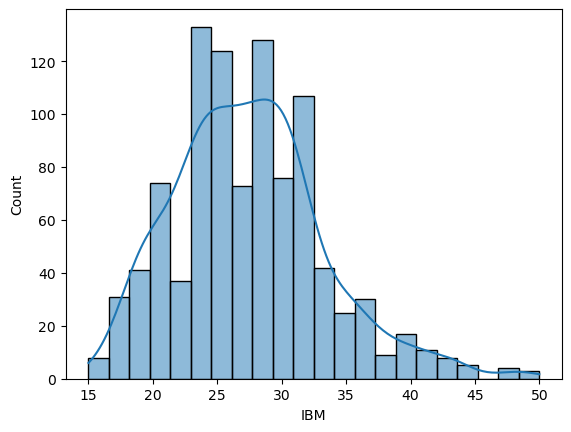

In [68]:
sns.histplot(data['IBM'], kde = True)

#### Handle Outliers

In [69]:
data['IBM'] = np.log1p(data['IBM'])

<Axes: xlabel='IBM', ylabel='Count'>

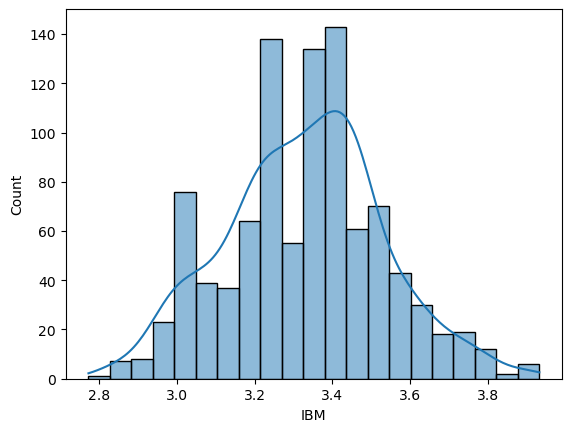

In [70]:
sns.histplot(data['IBM'], kde = True)

In [71]:
data.drop(columns=['Height', 'Weight'], inplace=True)

In [72]:
bins = np.arange(15000, 42000, 2000)
def get_bin_idx(label, bins):
    return np.digitize(label, bins) - 1

def apply_lds(target_data, bins, kernel_size=5, sigma=2):
    bin_index_per_label = [get_bin_idx(label, bins) for label in target_data]
    num_samples_of_bins = dict(Counter(bin_index_per_label))
    emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(len(bins)-1)]
    
    def get_lds_kernel_window(kernel='gaussian', ks=kernel_size, sigma=sigma):
        x = np.arange(-ks // 2 + 1, ks // 2 + 1)
        kernel_window = np.exp(-0.5 * (x / sigma) ** 2)
        return kernel_window / kernel_window.sum()
    
    kernel_window = get_lds_kernel_window(kernel='gaussian', ks=kernel_size, sigma=sigma)
    eff_label_dist = convolve1d(np.array(emp_label_dist), weights=kernel_window, mode='constant')
    return eff_label_dist, emp_label_dist

In [73]:
best_ks, best_sigma = 7, 3
eff_label_dist, _ = apply_lds(data['PremiumPrice'].values, bins, kernel_size=best_ks, sigma=best_sigma)
data['SmoothedTarget'] = data['PremiumPrice'].apply(lambda x: eff_label_dist[get_bin_idx(x, bins)])

<Axes: xlabel='SmoothedTarget', ylabel='Count'>

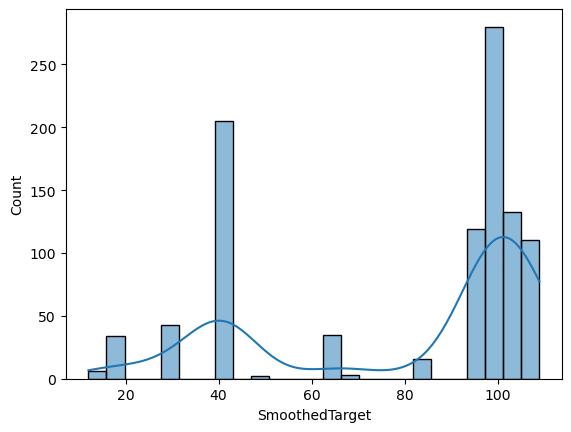

In [74]:
sns.histplot(data['SmoothedTarget'] , kde= True, bins = 25)

<Axes: xlabel='PremiumPrice', ylabel='Count'>

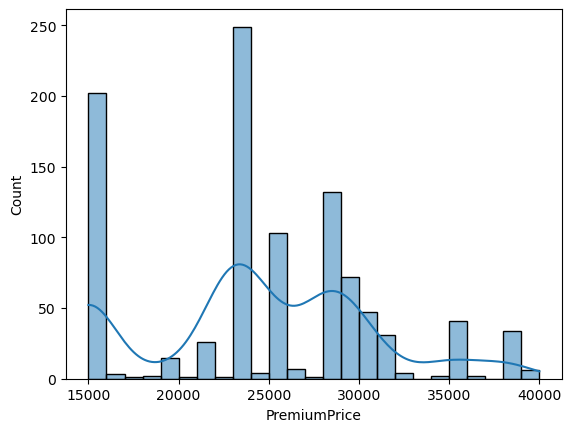

In [75]:
sns.histplot(data['PremiumPrice'] , kde= True, bins = 25)

In [76]:
data1 = pd.get_dummies(data, columns=['NumberOfMajorSurgeries'], drop_first=False)

In [77]:
data1.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,PremiumPrice,IBM,SmoothedTarget,NumberOfMajorSurgeries_0,NumberOfMajorSurgeries_1,NumberOfMajorSurgeries_2,NumberOfMajorSurgeries_3
0,45,0,0,0,0,0,0,25000,3.218876,109,True,False,False,False
1,60,1,0,0,0,0,0,29000,3.178054,95,True,False,False,False
2,36,1,1,0,0,0,0,23000,3.218876,100,False,True,False,False
3,52,1,1,0,1,0,0,28000,3.367296,104,False,False,True,False
4,38,0,0,0,1,0,0,23000,3.496508,100,False,True,False,False


In [78]:
data1 = data1.astype({'NumberOfMajorSurgeries_0': 'int', 
                    'NumberOfMajorSurgeries_1': 'int',
                    'NumberOfMajorSurgeries_2': 'int', 
                    'NumberOfMajorSurgeries_3': 'int'})

In [79]:
data1.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,PremiumPrice,IBM,SmoothedTarget,NumberOfMajorSurgeries_0,NumberOfMajorSurgeries_1,NumberOfMajorSurgeries_2,NumberOfMajorSurgeries_3
0,45,0,0,0,0,0,0,25000,3.218876,109,1,0,0,0
1,60,1,0,0,0,0,0,29000,3.178054,95,1,0,0,0
2,36,1,1,0,0,0,0,23000,3.218876,100,0,1,0,0
3,52,1,1,0,1,0,0,28000,3.367296,104,0,0,1,0
4,38,0,0,0,1,0,0,23000,3.496508,100,0,1,0,0


In [80]:
data =data1

In [81]:
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,PremiumPrice,IBM,SmoothedTarget,NumberOfMajorSurgeries_0,NumberOfMajorSurgeries_1,NumberOfMajorSurgeries_2,NumberOfMajorSurgeries_3
0,45,0,0,0,0,0,0,25000,3.218876,109,1,0,0,0
1,60,1,0,0,0,0,0,29000,3.178054,95,1,0,0,0
2,36,1,1,0,0,0,0,23000,3.218876,100,0,1,0,0
3,52,1,1,0,1,0,0,28000,3.367296,104,0,0,1,0
4,38,0,0,0,1,0,0,23000,3.496508,100,0,1,0,0


#### Model building

In [82]:
X = data.drop(['PremiumPrice','SmoothedTarget'], axis=1)
y_original = data['PremiumPrice'].values
y_smoothed = data['SmoothedTarget'].values

# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_original, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(X, y_smoothed, test_size=0.3, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, test_size=0.33, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train_s = scaler.fit_transform(X_train_s)
X_val_s = scaler.transform(X_val_s)
X_test_s = scaler.transform(X_test_s)



In [83]:
# Hyperparameter Tuning for Decision Tree and Random Forest
param_grid = {'max_depth': [3, 5, 10, 15, 20]}

dt = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
print("Best max_depth for Decision Tree:", dt_grid.best_params_)
print("Decision Tree Grid Search Results:")
dt_results = pd.DataFrame(dt_grid.cv_results_)
print(dt_results[['param_max_depth', 'mean_test_score']])

rf = RandomForestRegressor(n_estimators=100)
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("Best max_depth for Random Forest:", rf_grid.best_params_)
print("Random Forest Grid Search Results:")
rf_results = pd.DataFrame(rf_grid.cv_results_)
print(rf_results[['param_max_depth', 'mean_test_score']])

Best max_depth for Decision Tree: {'max_depth': 3}
Decision Tree Grid Search Results:
   param_max_depth  mean_test_score
0                3    -1.388270e+07
1                5    -1.532577e+07
2               10    -2.603289e+07
3               15    -2.444247e+07
4               20    -2.096667e+07
Best max_depth for Random Forest: {'max_depth': 5}
Random Forest Grid Search Results:
   param_max_depth  mean_test_score
0                3    -1.277389e+07
1                5    -1.185855e+07
2               10    -1.248649e+07
3               15    -1.255168e+07
4               20    -1.266743e+07


In [84]:
models = {
    "Ridge Regression (L2)": Ridge(alpha=1.0),
    "Lasso Regression (L1)": Lasso(alpha=0.1),
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', scale_pos_weight=1.5)
}


In [85]:
best_rf

RandomForestRegressor(max_depth=5)

In [86]:
# Train and Evaluate Models on Original Target
trained_models_original = {}
for name, model in models.items():
    trained_models_original[name] = model.fit(X_train, y_train)

results_original_validation = {}
results_original_test = {}
for name, model in trained_models_original.items():
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    results_original_validation[name] = {
        "MAE": mean_absolute_error(y_val, y_pred_val),
        "MSE": mean_squared_error(y_val, y_pred_val),
        "R2": r2_score(y_val, y_pred_val)
    }
    results_original_test[name] = {
        "MAE": mean_absolute_error(y_test, y_pred_test),
        "MSE": mean_squared_error(y_test, y_pred_test),
        "R2": r2_score(y_test, y_pred_test)
    }

In [87]:
# Train and Evaluate Models on Smoothed Target
trained_models_smoothed = {}
for name, model in models.items():
    trained_models_smoothed[name] = model.fit(X_train_s, y_train_s)

results_smoothed_validation = {}
results_smoothed_test = {}
for name, model in trained_models_smoothed.items():
    y_pred_val_s = model.predict(X_val_s)
    y_pred_test_s = model.predict(X_test_s)
    results_smoothed_validation[name] = {
        "MAE": mean_absolute_error(y_val_s, y_pred_val_s),
        "MSE": mean_squared_error(y_val_s, y_pred_val_s),
        "R2": r2_score(y_val_s, y_pred_val_s)
    }
    results_smoothed_test[name] = {
        "MAE": mean_absolute_error(y_test_s, y_pred_test_s),
        "MSE": mean_squared_error(y_test_s, y_pred_test_s),
        "R2": r2_score(y_test_s, y_pred_test_s)
    }

##### Test model

In [88]:
# Function to print model performance in a readable format
def print_model_performance(results, title):
    print(f"\n{title}:")
    # Create a DataFrame from the dictionary
    df = pd.DataFrame(results).T
    # Print the DataFrame in a nice table format
    print(df.to_string(float_format="%.4f"))

# Print the results
print_model_performance(results_original_validation, "Model Performance on Validation Data (original Target)")
print_model_performance(results_original_test, "Model Performance on Test Data (Original Target)")
print_model_performance(results_smoothed_validation, "Model Performance on Validation Data (Smoothed Target)")
print_model_performance(results_smoothed_test, "Model Performance on Test Data (Smoothed Target)")


Model Performance on Validation Data (original Target):
                            MAE           MSE     R2
Ridge Regression (L2) 2771.2691 14905803.3695 0.6719
Lasso Regression (L1) 2770.0845 14896728.7067 0.6721
Decision Tree         2205.3372 11667295.1504 0.7432
Random Forest         2031.7706 10146304.8404 0.7767
XGBoost               1890.0125 13763763.0028 0.6970

Model Performance on Test Data (Original Target):
                            MAE          MSE     R2
Ridge Regression (L2) 2385.2017 9729890.2046 0.7584
Lasso Regression (L1) 2382.9699 9716167.7538 0.7588
Decision Tree         1753.4041 6555070.5549 0.8372
Random Forest         1541.6969 5188024.0711 0.8712
XGBoost               1516.8197 5969098.0584 0.8518

Model Performance on Validation Data (Smoothed Target):
                          MAE      MSE     R2
Ridge Regression (L2) 19.0874 592.6793 0.3964
Lasso Regression (L1) 19.1241 594.1894 0.3948
Decision Tree          9.8713 322.0669 0.6720
Random Forest        

### Summary
* **Random Forest** is the best model across both Original & Smoothed targets.

Original Target: Best R² = 0.8609
Smoothed Target: Best R² = 0.7383
MAE is significantly lower for smoothed data, meaning better predictions in absolute terms.
Smoothing helps stabilize performance but lowers R² slightly.

The smoothed target reduces variance, making the models less prone to overfitting.
However, the R² score slightly drops, indicating it removes some valuable signal.
Linear Models (Ridge/Lasso) are not suitable.

R² for Ridge/Lasso is too low (~0.31-0.39), confirming that a linear assumption is insufficient.
Decision Tree is prone to overfitting.

The gap between Validation and Test R² is high (0.743 → 0.837 for Original).